## Dependencies

In [1]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Stats Stuff
from scipy import stats
from scipy.stats import skew
import statsmodels.api as sm


# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

## Importing and Prepping Schedules

In [2]:
schedules_df = nfl.import_schedules([2024])

In [3]:
def get_upcoming_week(schedule):
    """
    Finds the nearest upcoming week where games have not yet been played.
    """
    # Filter out games where both home_score and away_score are NaN (future games)
    future_games = schedule[schedule['home_score'].isna() & schedule['away_score'].isna()]
    
    # Find the soonest week with future games
    upcoming_week = future_games['week'].min()
    
    return upcoming_week

In [4]:
get_upcoming_week(schedules_df)

5

In [5]:
schedules_df

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,home_score,location,result,total,overtime,old_game_id,gsis,nfl_detail_id,pfr,pff,espn,ftn,away_rest,home_rest,away_moneyline,home_moneyline,spread_line,away_spread_odds,home_spread_odds,total_line,under_odds,over_odds,div_game,roof,surface,temp,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
6706,2024_01_BAL_KC,2024,REG,1,2024-09-05,Thursday,20:20,BAL,20.0,KC,27.0,Home,7.0,47.0,0.0,2024090500,59508,NaN,202409050kan,NaN,401671789,6449.0,7,7,124.0,-148.0,3.0,-118.0,-102.0,46.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,00-0034796,00-0033873,Lamar Jackson,Patrick Mahomes,John Harbaugh,Andy Reid,Shawn Hochuli,KAN00,GEHA Field at Arrowhead Stadium
6707,2024_01_GB_PHI,2024,REG,1,2024-09-06,Friday,20:15,GB,29.0,PHI,34.0,Neutral,5.0,63.0,0.0,2024090600,59509,NaN,202409060phi,NaN,401671805,6450.0,7,7,110.0,-130.0,2.0,-110.0,-110.0,49.5,-112.0,-108.0,0,outdoors,NaN,NaN,NaN,00-0036264,00-0036389,Jordan Love,Jalen Hurts,Matt LaFleur,Nick Sirianni,Ron Torbert,SAO00,Arena Corinthians
6708,2024_01_PIT_ATL,2024,REG,1,2024-09-08,Sunday,13:00,PIT,18.0,ATL,10.0,Home,-8.0,28.0,0.0,2024090800,59510,NaN,202409080atl,NaN,401671744,6451.0,7,7,160.0,-192.0,4.0,-110.0,-110.0,43.0,-115.0,-105.0,0,closed,fieldturf,NaN,NaN,00-0036945,00-0029604,Justin Fields,Kirk Cousins,Mike Tomlin,Raheem Morris,Brad Rogers,ATL97,Mercedes-Benz Stadium
6709,2024_01_ARI_BUF,2024,REG,1,2024-09-08,Sunday,13:00,ARI,28.0,BUF,34.0,Home,6.0,62.0,0.0,2024090801,59511,NaN,202409080buf,NaN,401671617,6452.0,7,7,250.0,-310.0,6.5,-105.0,-115.0,46.0,-112.0,-108.0,0,outdoors,a_turf,61.0,20.0,00-0035228,00-0034857,Kyler Murray,Josh Allen,Jonathan Gannon,Sean McDermott,Tra Blake,BUF00,New Era Field
6710,2024_01_TEN_CHI,2024,REG,1,2024-09-08,Sunday,13:00,TEN,17.0,CHI,24.0,Home,7.0,41.0,0.0,2024090802,59512,NaN,202409080chi,NaN,401671719,6453.0,7,7,164.0,-198.0,4.0,-108.0,-112.0,43.0,-110.0,-110.0,0,outdoors,grass,67.0,8.0,00-0039152,00-0039918,Will Levis,Caleb Williams,Brian Callahan,Matt Eberflus,Shawn Smith,CHI98,Soldier Field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6973,2024_18_MIA_NYJ,2024,REG,18,2025-01-05,Sunday,13:00,MIA,NaN,NYJ,NaN,Home,NaN,NaN,NaN,2025010511,59775,NaN,202501050nyj,NaN,401671833,6716.0,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,fieldturf,NaN,NaN,NaN,NaN,NaN,NaN,Mike McDaniel,Robert Saleh,NaN,NYC01,MetLife Stadium
6974,2024_18_NYG_PHI,2024,REG,18,2025-01-05,Sunday,13:00,NYG,NaN,PHI,NaN,Home,NaN,NaN,NaN,2025010512,59776,NaN,202501050phi,NaN,401671841,6717.0,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Brian Daboll,Nick Sirianni,NaN,PHI00,Lincoln Financial Field
6975,2024_18_CIN_PIT,2024,REG,18,2025-01-05,Sunday,13:00,CIN,NaN,PIT,NaN,Home,NaN,NaN,NaN,2025010513,59777,NaN,202501050pit,NaN,401671836,6718.0,7,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Zac Taylor,Mike Tomlin,NaN,PIT00,Acrisure Stadium
6976,2024_18_NO_TB,2024,REG,18,2025-01-05,Sunday,13:00,NO,NaN,TB,NaN,Home,NaN,NaN,NaN,2025010514,59778,NaN,202501050tam,NaN,401671828,6719.0,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,outdoors,grass,NaN,NaN,NaN,NaN,NaN,NaN,Dennis Allen,Todd Bowles,NaN,TAM00,Raymond James Stadium


## Importing PBP Data

In [6]:
# Select only the relevant columns
columns = ['game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer DF Prep

In [7]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['game_id', 'passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Reorder the columns
passer_df = passer_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass' ,'game_id', 'passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

## Defense DF Prep

In [8]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Reorder the columns
defense_df = defense_df[['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]

## Preprocessing

In [9]:
def calculate_offensive_ewma(passer_df):
    """
    Calculates EWMA for offensive columns using previous weeks' data, ensuring no leakage by excluding the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, excluding the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return passer_df

In [10]:
def pass_cleaner(passer_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    passer_df.drop(columns=['home_team', 'away_team', 'complete_pass', 'incomplete_pass', 'completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe', 'home_team', 'away_team', 
                                    'complete_pass', 'incomplete_pass'], inplace=True)
    
    return passer_df

In [11]:
passer_emwa = calculate_offensive_ewma(passer_df)

In [12]:
passer_prepped = pass_cleaner(passer_emwa)

In [13]:
def calculate_defensive_ewma(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.shift().ewm(min_periods=1, span=2).mean())

    return defense_df

In [14]:
def def_cleaner(defense_df):
    """
    Preps passer df for merging; drops unnecessary columns
    """
    # Drop the non-ewma columns
    defense_df.drop(columns=['passing_yards','completion_percentage',
                            'air_yards', 'yards_after_catch', 'epa',     
                            'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe', 'complete_pass', 'incomplete_pass',
                            'home_team', 'away_team'
                            ], inplace=True)
    
    return defense_df

In [15]:
defense_ewma = calculate_defensive_ewma(defense_df)

In [16]:
defense_prepped = def_cleaner(defense_ewma)

In [17]:
# Merge the defense and passer dataframes together
full_with_ewma = passer_prepped.merge(defense_prepped, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

# Get rid of flukey rows
filtered_with_ewma = full_with_ewma[(full_with_ewma['pass_attempts'] > 8) & (full_with_ewma['passing_yards'] >= 10)]

#Ford Field is empty, you hate to see that
filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_576\3866188713.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_with_ewma['surface'].replace('', 'fieldturf', inplace=True)


## Week 1 is NaN's (duh, we use past weeks for EWMA's) for MVP I'll just get rid but for future seasons/rookies I do need a strategy

In [18]:
filtered_with_ewma = filtered_with_ewma.dropna()

In [19]:
filtered_with_ewma

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
1,2015_14_TEN_NYJ,M.Mariota,TEN,NYJ,2015,14,274.0,False,38.0,outdoors,fieldturf,0.662542,29.686526,314.591722,79.412851,3.124743,1.142833,3.993124,3.449397,2.703326,252.764802,0.304378,True,0.551598,38.405423,338.461222,158.893896,2.111368,0.906202,7.428869,2.892293,1.610071,302.881906,-8.933428
3,2019_16_DET_DEN,D.Lock,DEN,DET,2019,16,192.0,True,33.0,outdoors,grass,0.566075,35.076923,225.538462,152.538462,-4.113424,1.000000,8.769231,1.615385,0.846154,225.615385,-10.131588,False,0.710187,37.944764,397.871907,164.435317,18.734286,0.765468,5.085061,1.727529,3.147564,392.540428,4.387478
5,2014_05_KC_SF,C.Kaepernick,SF,KC,2014,5,201.0,True,26.0,outdoors,grass,0.640239,30.800000,233.725000,94.700000,-1.967777,0.900000,4.275000,3.250000,1.700000,225.900000,-2.948886,False,0.669270,31.350000,220.250000,161.650000,-8.580675,1.350000,2.750000,3.100000,1.850000,225.500000,-3.892643
7,2014_04_TB_PIT,B.Roethlisberger,PIT,TB,2014,4,314.0,True,39.0,outdoors,grass,0.725199,30.692308,154.230769,125.923077,0.973090,0.307692,3.000000,1.384615,1.461538,213.846154,4.614742,False,0.846395,27.923077,297.615385,82.230769,17.722273,0.692308,2.538462,1.230769,2.230769,314.230769,18.938343
9,2014_07_HOU_PIT,B.Roethlisberger,PIT,HOU,2014,7,265.0,True,33.0,outdoors,grass,0.583703,39.370879,393.818681,84.978022,-5.685573,0.678571,4.780220,2.645604,1.164835,243.887363,-2.196885,False,0.608151,41.771978,393.931319,130.868132,10.901050,1.054945,7.653846,2.406593,2.653846,344.480769,-3.208265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6790,2023_05_NYJ_DEN,Z.Wilson,NYJ,DEN,2023,5,199.0,False,25.0,outdoors,grass,0.656960,36.425000,273.975000,68.675000,-2.452351,0.250000,8.825000,2.300000,1.450000,216.950000,2.806705,True,0.828698,32.800000,272.625000,150.575000,12.680950,0.700000,6.975000,3.000000,4.025000,338.150000,19.325084
6791,2023_06_PHI_NYJ,Z.Wilson,NYJ,PHI,2023,6,186.0,True,33.0,outdoors,fieldturf,0.725937,28.776860,211.735537,95.000000,-5.609730,0.752066,6.264463,3.438017,0.479339,204.933884,5.735478,False,0.607186,37.231405,366.900826,104.636364,0.120687,0.082645,8.033058,4.008264,1.760331,235.818182,-2.727409
6792,2023_08_NYJ_NYG,Z.Wilson,NYJ,NYG,2023,8,240.0,False,35.0,outdoors,fieldturf,0.625680,31.596154,243.288462,95.667582,-7.760983,0.250000,7.423077,4.480769,0.159341,192.293956,-4.110268,True,0.586082,36.849039,324.931382,109.939616,-10.821895,1.037511,7.174748,4.141812,0.636780,234.056725,-2.153373
6793,2023_09_LAC_NYJ,Z.Wilson,NYJ,LAC,2023,9,263.0,True,49.0,outdoors,fieldturf,0.532327,33.866423,264.439158,109.895700,-12.364552,0.083257,8.474840,4.160110,0.720037,224.112534,-12.592654,False,0.725654,36.130833,275.906679,144.403477,-2.390726,1.590119,2.924977,1.479414,0.993596,279.162855,-0.123320


## Modeling

In [20]:
# Define the target and features
target = 'passing_yards'
features = filtered_with_ewma.columns.drop(['pass_attempts', 'passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week', 'game_id'])

# Define categorical and numeric columns
categorical_columns = ['roof', 'surface']
numeric_columns = [col for col in features if col not in categorical_columns]

# Split the data into training (up to 2023) and testing (2024)
train_data = filtered_with_ewma[filtered_with_ewma['season'] <= 2023]
test_data = filtered_with_ewma[filtered_with_ewma['season'] == 2024]

# Separate features and target for both training and testing
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])

# Apply the transformations to the training and test sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed data into a LightGBM-compatible format
train_data_lgb = lgb.Dataset(X_train_transformed, label=y_train)
test_data_lgb = lgb.Dataset(X_test_transformed, label=y_test, reference=train_data_lgb)

# Set up the parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train the model with early stopping
lgb_model = lgb.train(params, train_data_lgb, valid_sets=[test_data_lgb], callbacks=[lgb.early_stopping(stopping_rounds=10)], num_boost_round=1000)

# Make predictions on the test set
y_pred = lgb_model.predict(X_test_transformed, num_iteration=lgb_model.best_iteration)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 73.7195
RMSE: 73.71950584123508


In [21]:
features

Index(['home_flag_passer', 'roof', 'surface',
       'completion_percentage_ewma_passer', 'pass_attempts_ewma_passer',
       'air_yards_ewma_passer', 'yards_after_catch_ewma_passer',
       'epa_ewma_passer', 'interception_ewma_passer', 'qb_hit_ewma_passer',
       'sack_ewma_passer', 'pass_touchdown_ewma_passer',
       'passing_yards_ewma_passer', 'cpoe_ewma_passer', 'home_flag_defense',
       'completion_percentage_ewma_defense', 'pass_attempts_ewma_defense',
       'air_yards_ewma_defense', 'yards_after_catch_ewma_defense',
       'epa_ewma_defense', 'interception_ewma_defense', 'qb_hit_ewma_defense',
       'sack_ewma_defense', 'pass_touchdown_ewma_defense',
       'passing_yards_ewma_defense', 'cpoe_ewma_defense'],
      dtype='object')

In [22]:
# Ensure test_data contains the 2024 season
test_data = filtered_with_ewma[filtered_with_ewma['season'] == 2024]

In [23]:
# Add predictions to the test_data (2024) DataFrame
test_data['predicted_passing_yards'] = y_pred

# Calculate whether the model over-predicted or under-predicted
test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']

# # Display the updated dataframe with actual, predicted, and over/under information
# test_data[['week', 'passer_player_name', 'passing_yards', 'predicted_passing_yards', 'pyoe']].sort_values(by='predicted_passing_yards', key=abs, ascending=False).tail(60)

C:\Users\bhugg\AppData\Local\Temp\ipykernel_576\2626295089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_passing_yards'] = y_pred
C:\Users\bhugg\AppData\Local\Temp\ipykernel_576\2626295089.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['pyoe'] = test_data['passing_yards'] - test_data['predicted_passing_yards']


## Trying to get next week

In [31]:
test_data.sort_values(by='week', ascending=False)

,game_id,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense,predicted_passing_yards,pyoe
2727,2024_05_TB_ATL,K.Cousins,ATL,TB,2024,5,509.0,True,55.0,closed,fieldturf,0.646741,32.000000,284.600000,124.150000,0.313961,0.950000,5.275000,1.250000,0.400000,234.350000,-2.920150,False,0.628487,32.925000,276.500000,78.550000,-7.468266,0.150000,5.300000,4.100000,0.675000,184.150000,-1.618399,273.373338,235.626662
1063,2024_05_TB_ATL,B.Mayfield,TB,ATL,2024,5,180.0,False,24.0,closed,fieldturf,0.676632,41.025000,245.975000,167.575000,1.375113,0.300000,3.850000,3.325000,1.750000,292.000000,-3.402642,True,0.771908,34.925000,193.700000,112.725000,0.571014,0.975000,4.075000,0.800000,0.525000,227.775000,4.751379,259.434828,-79.434828
2633,2024_04_DAL_NYG,D.Jones,NYG,DAL,2024,4,281.0,True,39.0,outdoors,fieldturf,0.662864,33.076923,240.230769,142.076923,6.654669,0.153846,8.076923,2.000000,1.846154,218.769231,3.869079,False,0.766011,17.153846,93.615385,143.076923,8.846120,0.384615,2.230769,0.692308,1.230769,195.076923,3.137374,235.730446,45.269554
4230,2024_04_MIN_GB,J.Love,GB,MIN,2024,4,389.0,True,51.0,outdoors,grass,0.515152,33.000000,312.000000,138.000000,2.811224,1.000000,4.000000,1.000000,2.000000,260.000000,-10.018557,False,0.699719,39.538462,270.923077,140.923077,-6.673934,1.769231,8.076923,5.230769,0.923077,300.461538,-2.606909,234.226003,154.773997
4193,2024_04_BUF_BAL,L.Jackson,BAL,BUF,2024,4,156.0,True,18.0,outdoors,grass,0.758954,20.692308,118.384615,140.153846,7.420703,0.230769,1.230769,0.538462,1.000000,204.000000,2.631912,False,0.612366,41.846154,311.692308,91.461538,-21.970688,1.384615,8.461538,4.230769,1.000000,202.846154,-4.659068,221.648098,-65.648098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2484,2024_02_NO_DAL,D.Carr,NO,DAL,2024,2,243.0,False,15.0,closed,matrixturf,0.826087,23.000000,200.000000,96.000000,8.547131,0.000000,1.000000,1.000000,3.000000,200.000000,13.704329,True,0.558140,43.000000,395.000000,102.000000,-23.115656,2.000000,17.000000,6.000000,1.000000,169.000000,-7.962810,240.149477,2.850523
2971,2024_02_CLE_JAX,D.Watson,CLE,JAX,2024,2,186.0,False,34.0,outdoors,grass,0.558140,43.000000,395.000000,102.000000,-23.115656,2.000000,17.000000,6.000000,1.000000,169.000000,-7.962810,True,0.621622,37.000000,228.000000,243.000000,4.323553,0.000000,4.000000,3.000000,1.000000,338.000000,-7.655266,208.667393,-22.667393
4164,2024_02_ATL_PHI,J.Hurts,PHI,ATL,2024,2,183.0,True,29.0,outdoors,grass,0.645161,31.000000,238.000000,170.000000,10.701968,2.000000,5.000000,2.000000,2.000000,278.000000,1.243478,False,0.739130,23.000000,128.000000,54.000000,-1.352276,0.000000,4.000000,2.000000,0.000000,156.000000,4.855539,236.841876,-53.841876
2630,2024_02_NYG_WAS,D.Jones,NYG,WAS,2024,2,178.0,False,28.0,outdoors,grass,0.550000,40.000000,216.000000,83.000000,-22.593838,2.000000,12.000000,5.000000,0.000000,186.000000,-10.656156,True,0.800000,30.000000,140.000000,187.000000,20.591764,0.000000,4.000000,1.000000,4.000000,289.000000,12.676064,215.016733,-37.016733


## Current Week Preprocessing

In [36]:
def calculate_ewma_tester_off(passer_df):
    """
    Calculates EWMA for offensive columns using the current and previous weeks' data, including the current week.
    Takes into account multiple seasons.
    """
    # Sort by passer, season, and week
    passer_df = passer_df.sort_values(by=['passer_player_name', 'season', 'week'])

    # Calculate the exponentially weighted moving average for each offensive feature, including the current week
    passer_df['completion_percentage_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_attempts_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['air_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['yards_after_catch_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['epa_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['interception_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['qb_hit_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['sack_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['pass_touchdown_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['passing_yards_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    passer_df['cpoe_ewma'] = passer_df.groupby(['passer_player_name', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return passer_df

In [37]:
def calculate_ewma_tester_def(defense_df):
    """
    Calculates EWMA for defensive columns using previous weeks' data (excluding the current week).
    """
    # Sort by 'defteam', 'season', and 'week' in ascending order (to ensure time order)
    defense_df = defense_df.sort_values(by=['defteam', 'season', 'week'])

    # Ensure proper grouping by both defteam and season
    defense_df['completion_percentage_ewma'] = defense_df.groupby(['defteam', 'season'])['completion_percentage']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())
    
    defense_df['pass_attempts_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_attempts']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['air_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['air_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['yards_after_catch_ewma'] = defense_df.groupby(['defteam', 'season'])['yards_after_catch']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['epa_ewma'] = defense_df.groupby(['defteam', 'season'])['epa']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['interception_ewma'] = defense_df.groupby(['defteam', 'season'])['interception']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['qb_hit_ewma'] = defense_df.groupby(['defteam', 'season'])['qb_hit']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['sack_ewma'] = defense_df.groupby(['defteam', 'season'])['sack']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['pass_touchdown_ewma'] = defense_df.groupby(['defteam', 'season'])['pass_touchdown']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['passing_yards_ewma'] = defense_df.groupby(['defteam', 'season'])['passing_yards']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    defense_df['cpoe_ewma'] = defense_df.groupby(['defteam', 'season'])['cpoe']\
        .transform(lambda x: x.ewm(min_periods=1, span=2).mean())

    return defense_df

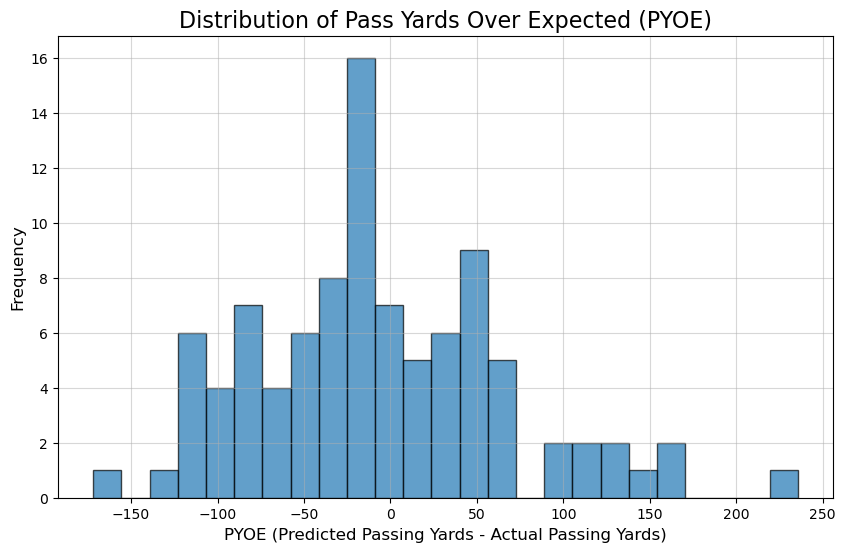

In [38]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['pyoe'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards Over Expected (PYOE)', fontsize=16)
plt.xlabel('PYOE (Predicted Passing Yards - Actual Passing Yards)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

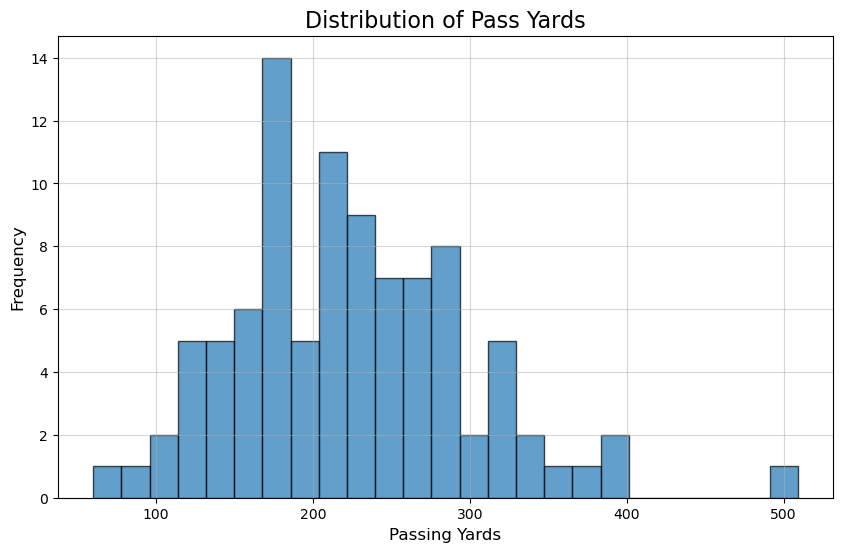

In [39]:
# Plotting the histogram of PYOE
plt.figure(figsize=(10, 6))
plt.hist(test_data['passing_yards'], bins=25, edgecolor='black', alpha=0.7)
plt.title('Distribution of Pass Yards', fontsize=16)
plt.xlabel('Passing Yards', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

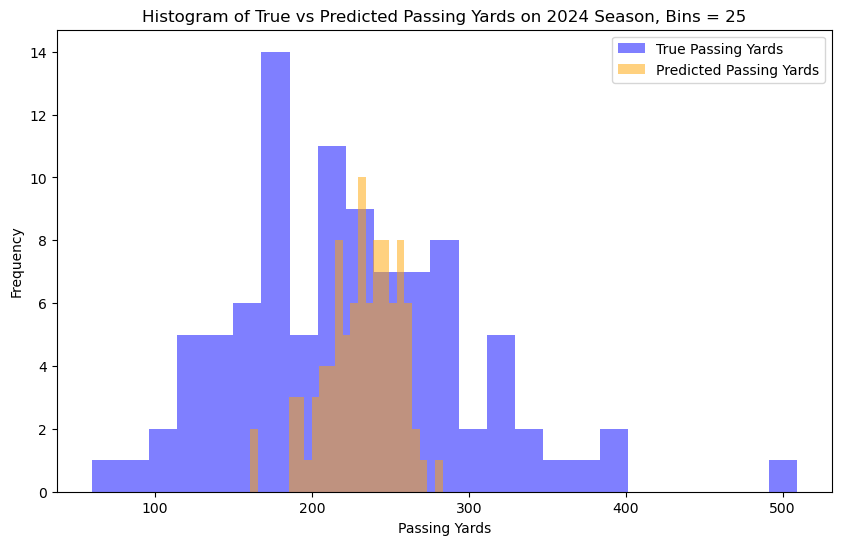

In [40]:
# Plotting the histogram of predicted passing yards and true passing yards
plt.figure(figsize=(10, 6))

# Plot histogram for true passing yards
plt.hist(test_data['passing_yards'], bins=25, alpha=0.5, label='True Passing Yards', color='blue')

# Plot histogram for predicted passing yards
plt.hist(test_data['predicted_passing_yards'], bins=25, alpha=0.5, label='Predicted Passing Yards', color='orange')

# Adding labels and title
plt.xlabel('Passing Yards')
plt.ylabel('Frequency')
plt.title('Histogram of True vs Predicted Passing Yards on 2024 Season, Bins = 25')
plt.legend(loc='upper right')

# Show the plot
plt.show()